Neccessary Modules

In [ ]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Input
from tensorflow.keras.utils import to_categorical

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, LocallyLinearEmbedding


Configuration

In [14]:
IMG_WIDTH = 48
IMG_HEIGHT = 48
NUM_CHANNELS = 3
INPUT_SHAPE = (IMG_HEIGHT, IMG_WIDTH, NUM_CHANNELS)
NUM_CLASSES = 10
NUM_VIZ_SAMPLES = 2000
EPOCHS_TRANSFER_LEARNING = 5

Method to plot the features

In [49]:
def plot_features_subplot(ax, features_2d, labels, technique_name, subplot_label):
    sns.scatterplot(x=features_2d[:, 0], y=features_2d[:, 1], hue=labels,
                    palette=sns.color_palette("tab10", n_colors=NUM_CLASSES),
                    legend="full", s=20, ax=ax)
    ax.set_title(f"({subplot_label}) {technique_name}")
    ax.set_xlabel(f"Comp 1")
    ax.set_ylabel(f"Comp 2")
    ax.legend(title='Digit', loc='best', fontsize='small')

Method to preprocess the image

In [16]:
def preprocess_image(images, target_height, target_width):
    # Resize
    images_resized = tf.image.resize(images[..., np.newaxis], [target_height, target_width]).numpy()
    # Convert to 3 channels by repeating the grayscale channel
    images_rgb = np.repeat(images_resized, NUM_CHANNELS, axis=-1)
    # Normalize
    images_normalized = images_rgb / 255.0
    return images_normalized

Load dataset and preprocess images

In [17]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# Preprocess the images
X_train_processed = preprocess_image(X_train, IMG_HEIGHT, IMG_WIDTH)
X_test_processed = preprocess_image(X_test, IMG_HEIGHT, IMG_WIDTH)

2025-06-21 21:56:15.358010: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 47040000 exceeds 10% of free system memory.
2025-06-21 21:56:15.402106: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 552960000 exceeds 10% of free system memory.
2025-06-21 21:56:22.330547: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 92160000 exceeds 10% of free system memory.


Take only the first 2000 test data to speed up the process

In [18]:
x_Viz = X_test_processed[:NUM_VIZ_SAMPLES]
y_Viz = y_test[:NUM_VIZ_SAMPLES]

print(f"X_test shape: {X_test_processed.shape}")
print(f"y_test shape: {y_test.shape}")

print(f"X_Viz shape: {x_Viz.shape}")
print(f"y_Viz shape: {y_Viz.shape}")

X_test shape: (10000, 48, 48, 3)
y_test shape: (10000,)
X_Viz shape: (2000, 48, 48, 3)
y_Viz shape: (2000,)


Load MobileNetV2 base model

In [ ]:
input_tensor = Input(shape=INPUT_SHAPE)
mobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)

# mobileNetV2_base.summary()

/tmp/ipykernel_12176/3990374152.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  mobileNetV2_base = MobileNetV2(weights='imagenet', include_top=False, input_tensor=input_tensor)


Feature extraction model before transfer learning

In [ ]:
x_before_tl = mobileNetV2_base.output
x_before_tl = GlobalAveragePooling2D()(x_before_tl)

feature_extractor_before_tl = Model(inputs=mobileNetV2_base.input, outputs=x_before_tl)


Extract Features (Before TL)

In [21]:
print("Extracting features BEFORE transfer learning...")
features_before_tl = feature_extractor_before_tl.predict(x_Viz, verbose=1)
print(f"Shape of features_before_tl: {features_before_tl.shape}")

Extracting features BEFORE transfer learning...


2025-06-21 21:56:24.248039: W external/local_xla/xla/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 55296000 exceeds 10% of free system memory.
/home/sanjoy-kumar/.local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_770']. Received: the structure of inputs=*
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 44ms/step
Shape of features_before_tl: (2000, 1280)


Applying PCA before TL...
Applying t-SNE before TL...
Applying LLE before TL...


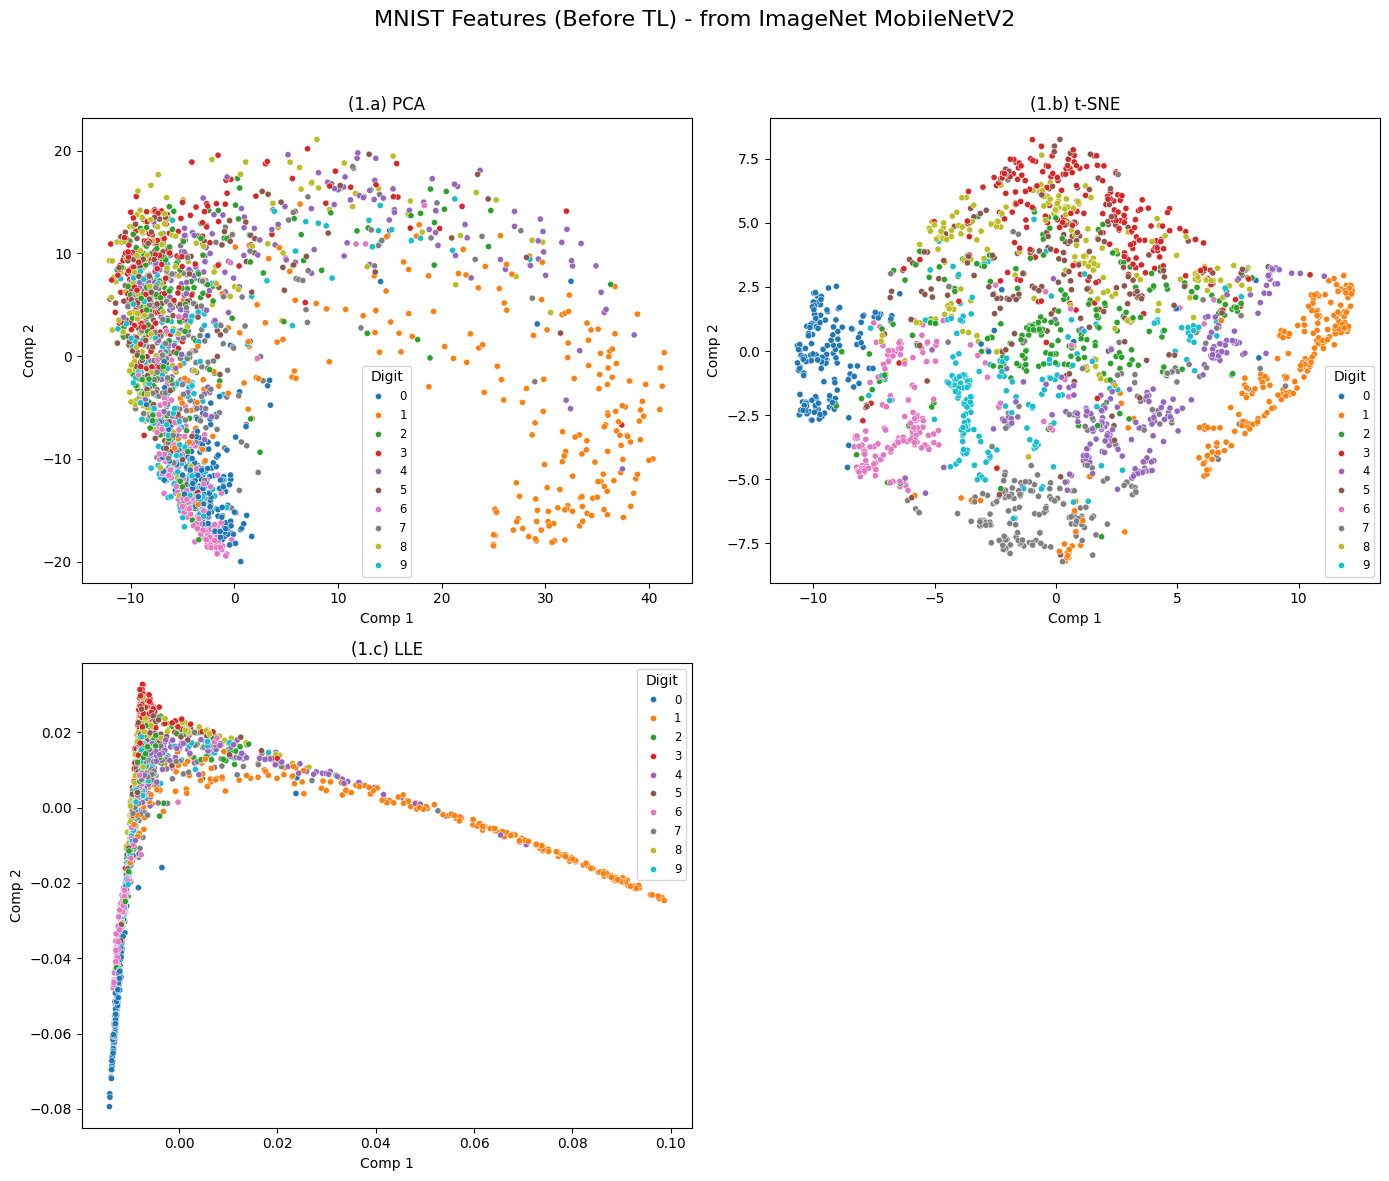

In [59]:
fig1, axes1 = plt.subplots(2, 2, figsize=(14, 12))  # 2x2 grid, adjust figsize as needed
fig1.suptitle("MNIST Features (Before TL) - from ImageNet MobileNetV2", fontsize=16)

# PCA Before TL
print("Applying PCA before TL...")
pca_before = PCA(n_components=2, random_state=42)
features_pca_before_tl = pca_before.fit_transform(features_before_tl)
plot_features_subplot(axes1[0, 0], features_pca_before_tl, y_Viz, "PCA", "1.a")

# t-SNE Before TL
print("Applying t-SNE before TL...")
tsne_before = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300, verbose=0)
features_tsne_before_tl = tsne_before.fit_transform(features_before_tl)
plot_features_subplot(axes1[0, 1], features_tsne_before_tl, y_Viz, "t-SNE", "1.b")

# LLE Before TL
print("Applying LLE before TL...")
lle_before = LocallyLinearEmbedding(n_components=2, n_neighbors=15, random_state=42, method='standard')
features_lle_before_tl = lle_before.fit_transform(features_before_tl)
plot_features_subplot(axes1[1, 0], features_lle_before_tl, y_Viz, "LLE", "1.c")

axes1[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95]) # Adjust rect for suptitle
plt.show()

Transfer learning

In [31]:
mobileNetV2_base.trainable = False  # Freeze the base model

# Unfreeze the last few layers for transfer learning
for layer in mobileNetV2_base.layers[-10:]:
    layer.trainable = True

x = mobileNetV2_base.output
x = GlobalAveragePooling2D(name="global_average_pooling")(x)
x = Dense(NUM_CLASSES, activation='softmax', name="predictions")(x)

model = Model(inputs=mobileNetV2_base.input, outputs=x)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Convert labels to categorical format
y_train_categorical = to_categorical(y_train, NUM_CLASSES)

model.fit(X_train_processed, y_train_categorical, epochs=EPOCHS_TRANSFER_LEARNING, batch_size=32, validation_split=0.2)


Epoch 1/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 101s 64ms/step - accuracy: 0.8738 - loss: 0.4664 - val_accuracy: 0.8015 - val_loss: 1.3532
Epoch 2/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 88s 59ms/step - accuracy: 0.9521 - loss: 0.1558 - val_accuracy: 0.8932 - val_loss: 0.5679
Epoch 3/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 87s 58ms/step - accuracy: 0.9627 - loss: 0.1170 - val_accuracy: 0.9419 - val_loss: 0.2828
Epoch 4/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 86s 57ms/step - accuracy: 0.9688 - loss: 0.1006 - val_accuracy: 0.9632 - val_loss: 0.1508
Epoch 5/5
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 109s 73ms/step - accuracy: 0.9736 - loss: 0.0805 - val_accuracy: 0.9523 - val_loss: 0.2213


# Extract Features (After TL) ---

In [37]:
feature_extractor_after_tl = Model(inputs=model.input, outputs=model.get_layer("global_average_pooling").output)

print("Extracting features AFTER transfer learning...")
features_after_tl = feature_extractor_after_tl.predict(x_Viz, verbose=1)
print(f"Shape of features_after_tl: {features_after_tl.shape}")

Extracting features AFTER transfer learning...


/home/sanjoy-kumar/.local/lib/python3.12/site-packages/keras/src/models/functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['keras_tensor_770']. Received: the structure of inputs=*
  warnings.warn(


63/63 ━━━━━━━━━━━━━━━━━━━━ 6s 59ms/step
Shape of features_after_tl: (2000, 1280)


Applying PCA after TL...
Applying t-SNE after TL...
Applying LLE after TL...


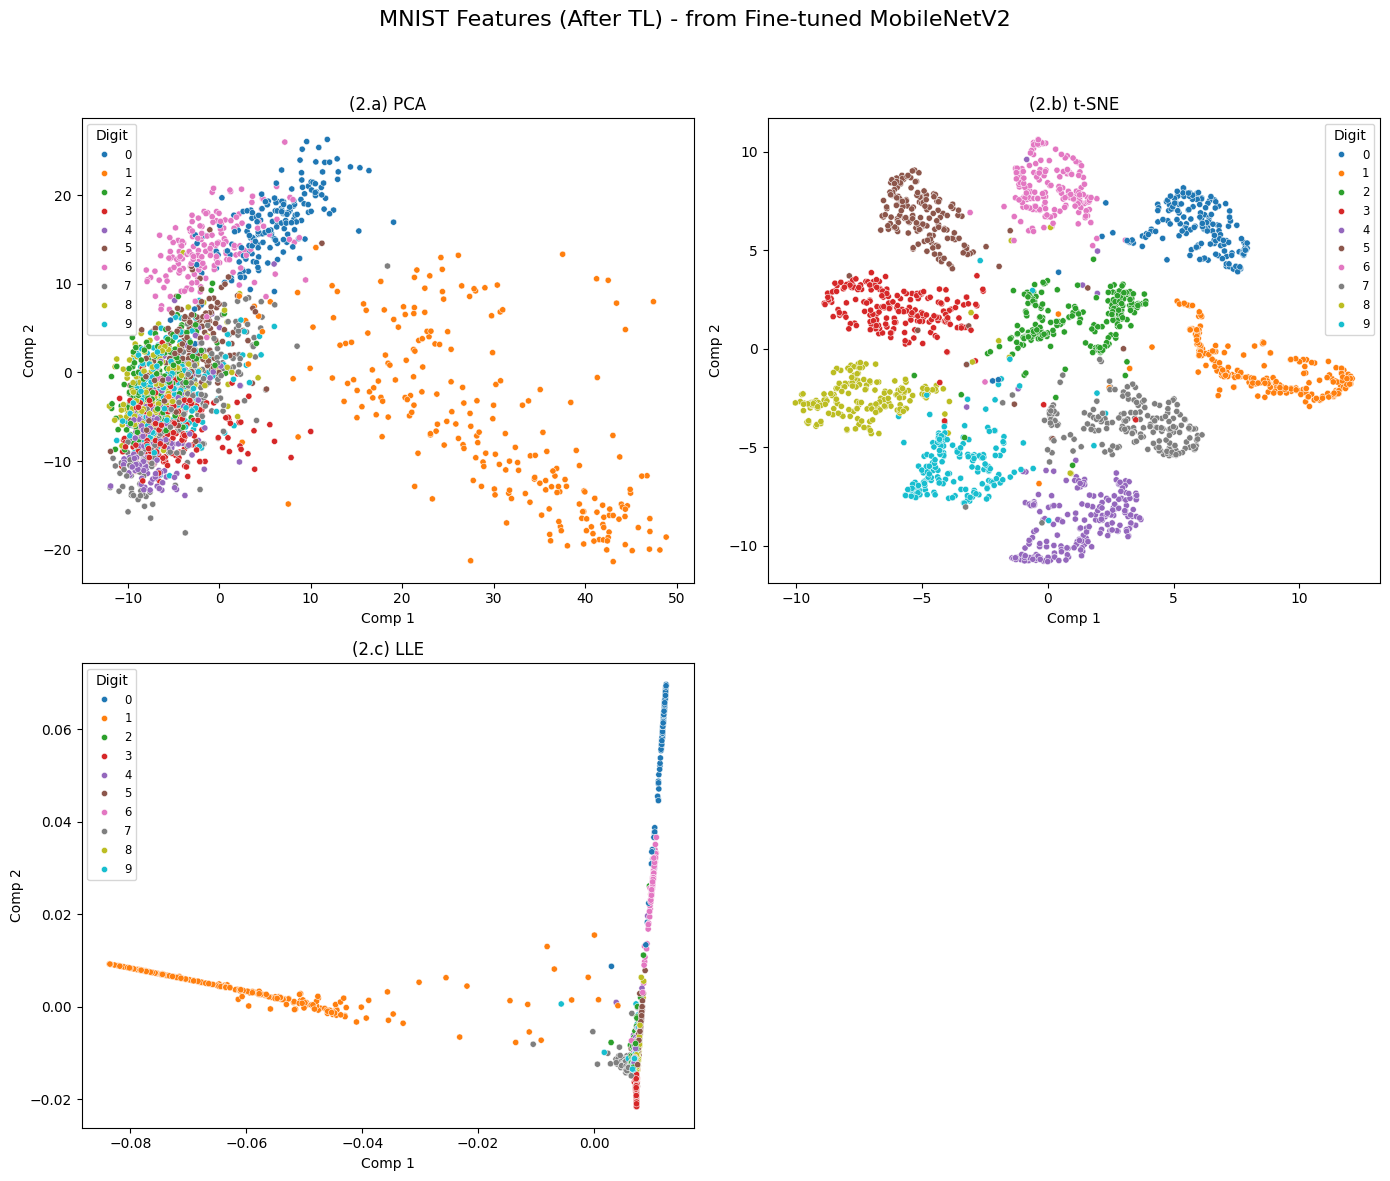

In [ ]:
fig2, axes2 = plt.subplots(2, 2, figsize=(14, 12))  # 2x2 grid, adjust figsize as needed
fig2.suptitle("MNIST Features (After TL) - from Fine-tuned MobileNetV2", fontsize=16)

# PCA After TL
print("Applying PCA after TL...")
pca_after = PCA(n_components=2, random_state=42)
features_pca_after_tl = pca_after.fit_transform(features_after_tl)
plot_features_subplot(axes2[0, 0], features_pca_after_tl, y_Viz, "PCA", "2.a")

# t-SNE After TL
print("Applying t-SNE after TL...")
tsne_after = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=300, verbose=0)
features_tsne_after_tl = tsne_after.fit_transform(features_after_tl)
plot_features_subplot(axes2[0, 1], features_tsne_after_tl, y_Viz, "t-SNE", "2.b")

# LLE After TL
print("Applying LLE after TL...")
lle_after = LocallyLinearEmbedding(n_components=2, n_neighbors=15, random_state=42, method='standard')
features_lle_after_tl = lle_after.fit_transform(features_after_tl)
plot_features_subplot(axes2[1, 0], features_lle_after_tl, y_Viz, "LLE", "2.c")

axes2[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()